In [1]:
import pandas as pd
import numpy as np
import json
import zipfile
import os
import math
from collections import Counter
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter
import random
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
import time

#### CHANGE THE VALUES IN THE CELL BELOW
##### It should correspond to the amount of .json files you want to read and the filepath were your archive.zip folder is that you downloaded from kaggle at the following link (https://www.kaggle.com/datasets/himanshuwagh/spotify-million/data)
##### **DO NOT EXCTRACT THE DATA, THE SCRIPT READS DIRECTLY FROM THE ZIP FOLDER**

In [2]:
#CHANGE THE VALUES HERE

amount_of_json_files_to_read = 3
zip_path = "C:/Users/use/Downloads/archive.zip"
os.chdir( "C:/Users/use/Downloads")

In [3]:
with open('spotify-million-metadata.json', 'r') as f:
    data = json.load(f)

In [3]:
playlist_rows = []
track_rows = []
file_rows = []

In [4]:
with zipfile.ZipFile(zip_path, 'r') as z:
    json_files = [f for f in z.namelist() if f.startswith("data/") and f.endswith(".json")]
    json_files.sort()
    
    for filename in json_files[:amount_of_json_files_to_read]:
        print(f"Reading {filename}...")
        with z.open(filename) as f:
            parsed = json.loads(f.read().decode("utf-8"))
            
            #metadata for file
            info = parsed.get("info", {})
            file_rows.append({
                "filename": filename,
                **info
            })
            
            #metadata playlist
            for pl in parsed["playlists"]:
                unique_artists = len({t["artist_name"] for t in pl["tracks"]})
                playlist_entry = {**pl}
                playlist_entry["num_artists"] = unique_artists
                playlist_entry["filename"] = filename
                playlist_rows.append(playlist_entry)
                
                #track metadata
                for track in pl["tracks"]:
                    track_entry = {**track}
                    track_entry["pid"] = pl.get("pid")
                    track_entry["filename"] = filename
                    track_rows.append(track_entry)


Reading data/mpd.slice.0-999.json...
Reading data/mpd.slice.1000-1999.json...
Reading data/mpd.slice.10000-10999.json...


In [5]:
df_playlists = pd.DataFrame(playlist_rows)
df_tracks = pd.DataFrame(track_rows)
df_files = pd.DataFrame(file_rows)

In [6]:
#df_full = df_tracks_playlists.merge(df_files, on="filename")
df_full= df_playlists.drop(columns = ["tracks"]).merge(df_tracks, on=["pid", "filename"], suffixes=("_playlist", "_track"))
df_full["track_id"] = df_full["track_uri"].str.split(":").str[-1]
df_full.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms_playlist,num_artists,...,description,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms_track,album_name,track_id
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,...,NaN,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,0UaMYEvWZi0ZqiDOoHU3YI
1,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,...,NaN,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,6I9VzXrHxO9rA9A5euc8Ak
2,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,...,NaN,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),0WqIKmW4BTrj3eJFmnCKMv
3,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,...,NaN,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,1AWQoqb9bSvzTjaLralEkT
4,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,...,NaN,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,1lzr43nnXAijIGYnCT8M8H


In [7]:
print(df_full.shape[0] == df_playlists["num_tracks"].sum()) #dq OK

True


In [8]:
kaggle = pd.read_csv("spotify_data.csv")
kaggle.head()
kaggle.columns

Index(['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'popularity',
       'year', 'genre', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')

In [9]:

# Standardize track URI/id if needed
# e.g., if Kaggle has a Spotify URL, strip it to get the URI or ID

# Join audio features onto df_full at track level
audio_cols = ["track_id","genre", "danceability", "energy", "valence", "tempo", "acousticness", "instrumentalness", "liveness"]  # adjust to actual cols
kaggle_audio = kaggle[audio_cols].drop_duplicates(subset=["track_id"])

df_full_enriched = df_full.merge(kaggle_audio, on="track_id", how="left")
df_full_enriched.head(100).to_excel("head.xlsx")

**Basic Visualization**

In [10]:
# ---------- Utility functions ----------

def safe_nunique(s: pd.Series) -> int:
    return int(s.dropna().nunique()) if s is not None else 0

def entropy_from_counts(counts):
    if not counts:
        return 0.0
    freqs = np.array(counts, dtype=float)
    probs = freqs / freqs.sum()
    probs = probs[probs > 0]
    ent = -np.sum(probs * np.log2(probs))
    max_ent = math.log2(len(probs)) if len(probs) > 1 else 1.0
    return float(ent / max_ent) if max_ent > 0 else 0.0

def top_k_from_series(s: pd.Series, k: int = 5):
    if s is None:
        return []
    vc = s.dropna().value_counts().head(k)
    return list(zip(vc.index.tolist(), vc.tolist()))

def repr_col(group: pd.DataFrame, col: str, default=None):
    if col in group.columns:
        vals = group[col].dropna().unique()
        return vals[0] if len(vals) > 0 else default
    return default


# ---------- Main aggregation function ----------
def compute_playlist_aggregates(df_full: pd.DataFrame):
    """
    Returns:
      - df_agg: one row per playlist with all duration metrics in MILLISECONDS and MINUTES (for readability)
      - extras: dict with top artists and top tracks per playlist
    """

    required_cols = [
        'pid', 'artist_uri', 'album_uri', 'track_uri', 'duration_ms_track'
    ]
    missing = [c for c in required_cols if c not in df_full.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    
    audio_columns = [
        c for c in [
            "danceability", "energy", "valence", "tempo",
            "acousticness", "instrumentalness", "liveness",
            "speechiness", "loudness"
        ] if c in df_full.columns
    ]    
    g = df_full.groupby('pid', as_index=False)

    agg_rows = []
    extras = {'top_artists': {}, 'top_tracks': {}}

    for pid, group in g:
        row = {}

        # ---------- Identifiers ----------
        row['pid'] = pid
        row['playlist_name'] = repr_col(group, 'name')
        #row['description'] = repr_col(group, 'description') #not super relevant here, most people don't put a description

        # ---------- Own Counts ----------
        #row['num_tracks_actual'] = int(group.shape[0]) #doesn't work, to be investigateed 
        row['num_unique_tracks'] = safe_nunique(group['track_uri'])
        row['num_unique_artists'] = safe_nunique(group['artist_uri'])
        row['num_unique_albums'] = safe_nunique(group['album_uri'])
        
        # ---------- Playlist-level metadata ----------
        row['num_tracks_reported'] = int(repr_col(group, 'num_tracks', 0))
        row['num_albums_reported'] = int(repr_col(group, 'num_albums', 0))
        row['num_artists_reported'] = int(repr_col(group, 'num_artists', 0))
        row['num_followers'] = int(repr_col(group, 'num_followers', 0))
        row['num_edits'] = int(repr_col(group, 'num_edits', 0))
        #row['collaborative'] = bool(repr_col(group, 'collaborative', False)) collaborative is not stored as a boolean
        # Get the value as string first (or default "false")
        collab_str = str(repr_col(group, 'collaborative', 'false')).lower()
        # Convert to boolean
        row['collaborative'] = collab_str == 'true'
        row['modified_at'] = repr_col(group, 'modified_at')

        # ---------- DURATIONS (IN MINUTES) ----------
        total_ms = group['duration_ms_track'].sum(skipna=True)
        mean_ms = group['duration_ms_track'].mean(skipna=True)
        median_ms = group['duration_ms_track'].median(skipna=True)
        
        row['total_duration_tracks_ms'] = int(group['duration_ms_track'].sum(skipna=True))
        row['mean_track_duration_ms'] = float(group['duration_ms_track'].mean(skipna=True))
        row['median_track_duration_ms'] = float(group['duration_ms_track'].median(skipna=True))
        row['duration_ms_playlist_reported'] = int(
            repr_col(group, 'duration_ms_playlist', 0)
        )

        
       
        row['total_duration_tracks_min'] = float(total_ms / 60000.0)
        row['mean_track_duration_min'] = float(mean_ms / 60000.0)
        row['median_track_duration_min'] = float(median_ms / 60000.0)

        row['duration_playlist_reported_min'] = float(
            repr_col(group, 'duration_ms_playlist', 0) / 60000.0
        )

        # ---------- Structural ratios ----------
        row['artists_per_track'] = row['num_unique_artists'] / max(1, row['num_unique_tracks'])
        row['albums_per_track'] = row['num_unique_albums'] / max(1, row['num_unique_tracks'])
        row['tracks_per_artist'] = row['num_unique_tracks'] / max(1, row['num_unique_artists'])

        # ---------- Duplicate analysis ----------
        track_vc = group['track_uri'].dropna().value_counts()
        dup_occ = track_vc[track_vc > 1].sum()
        row['num_duplicate_track_occurrences'] = int(dup_occ)
#         row['fraction_duplicate_occurrences'] = float(
#             dup_occ / row['num_tracks_actual']
#         )

        # ---------- Diversity (entropy) ----------
        artist_counts = group['artist_uri'].dropna().value_counts().tolist()
        album_counts = group['album_uri'].dropna().value_counts().tolist()

        row['artist_entropy'] = entropy_from_counts(artist_counts)
        row['album_entropy'] = entropy_from_counts(album_counts)

#         # ----------  AUDIO FEATURE STATISTICS (NEW — FROM KAGGLE) too complex to be implemented, not enough data---------- 
#         if audio_columns:

#             audio_group = group[audio_columns].dropna(how="all")

#             for col in audio_columns:
#                 if col in audio_group.columns:
#                     row[f"mean_{col}"] = float(audio_group[col].mean())
#                     row[f"median_{col}"] = float(audio_group[col].median())
#                     row[f"std_{col}"] = float(audio_group[col].std())
#                     row[f"min_{col}"] = float(audio_group[col].min())
#                     row[f"max_{col}"] = float(audio_group[col].max())

#             # --- Audio entropy: diversity of "vibe"
#             # Lower = uniform vibe, higher = very varied
#             def audio_entropy(series):
#                 vals = series.dropna().tolist()
#                 if len(vals) == 0:
#                     return 0.0
#                 # bin the values into 10 equal-width bins
#                 hist, _ = np.histogram(vals, bins=10)
#                 return entropy_from_counts(hist.tolist())

#             # Example entropy metrics
#             for col in ["danceability", "energy", "valence"]:
#                 if col in audio_columns:
#                     row[f"{col}_entropy"] = audio_entropy(audio_group[col])

#             # --- Mood classification: 4-quadrant energy × valence
#             if "energy" in audio_columns and "valence" in audio_columns:
#                 e = audio_group["energy"].dropna().mean()
#                 v = audio_group["valence"].dropna().mean()
#                 if e is not None and v is not None:
#                     if e >= 0.5 and v >= 0.5:
#                         row["mood_quadrant"] = "Energetic + Positive"
#                     elif e >= 0.5 and v < 0.5:
#                         row["mood_quadrant"] = "Energetic + Dark"
#                     elif e < 0.5 and v >= 0.5:
#                         row["mood_quadrant"] = "Calm + Positive"
#                     else:
#                         row["mood_quadrant"] = "Calm + Dark"
#                 else:
#                     row["mood_quadrant"] = None


        # ---------- Top contributors ----------
        extras['top_artists'][pid] = top_k_from_series(group['artist_name'], k=5)
        extras['top_tracks'][pid] = top_k_from_series(group['track_name'], k=5)

        # ---------- Dataset provenance ----------
        row['filename'] = repr_col(group, 'filename')
        row['slice'] = repr_col(group, 'slice')
        row['version'] = repr_col(group, 'version')
        row['generated_on'] = repr_col(group, 'generated_on')

        # ---------- Duration consistency check (IN MINUTES) ----------
        row['duration_delta_min'] = (
            row['total_duration_tracks_min'] -
            row['duration_playlist_reported_min']
        )

        agg_rows.append(row)

    df_agg = pd.DataFrame(agg_rows).set_index('pid').sort_index()

    return df_agg, extras


# ---------- Example usage ----------
# df_agg, extras = compute_playlist_aggregates(df_full)
# df_agg.to_parquet("playlist_level_aggregates.parquet")


In [11]:
df_agg_2, extras = compute_playlist_aggregates(df_full_enriched)

In [12]:
df_agg, extras = compute_playlist_aggregates(df_full)

# Entropy 

    In the above aggregration, we use entropy as a measure of diversity, unpredictability or evenness in a distribution.

    For each playlist, we count how many times each artist (or album) appears. From these counts, we compute how evenly the tracks are distributed across artists/albums. 

    If one artist dominates --> entropy is low (near or equal to 0 if a single artist is in the playlist) 
    If all artists appear equally often --> entropy is high (near or equal to 1 if all the artists are different)

    This gives a normalized diversity score between 0 and 1. 

# Top k from series 

    This function finds the top-k most frequent values in a column (e.g top artists, or top tracks in a playlist) and it returns a list of (value, count) pairs

# Repr_col 

    When grouping by playlist, many playlist-level columns (name, description, followers, etc.) are repeated on every track row.
    This function extracts one representative value from the group.

    How it works

    - It checks the column exists.

    - It drops NaNs and collects the unique values.

    - It returns the first unique value.

    - If there is no usable value, it returns the default.

    **Why it’s useful**

    It safely extracts one clean playlist-level attribute when your dataset repeats the same value on every track.



Figure saved to: plots/unique_tracks.png


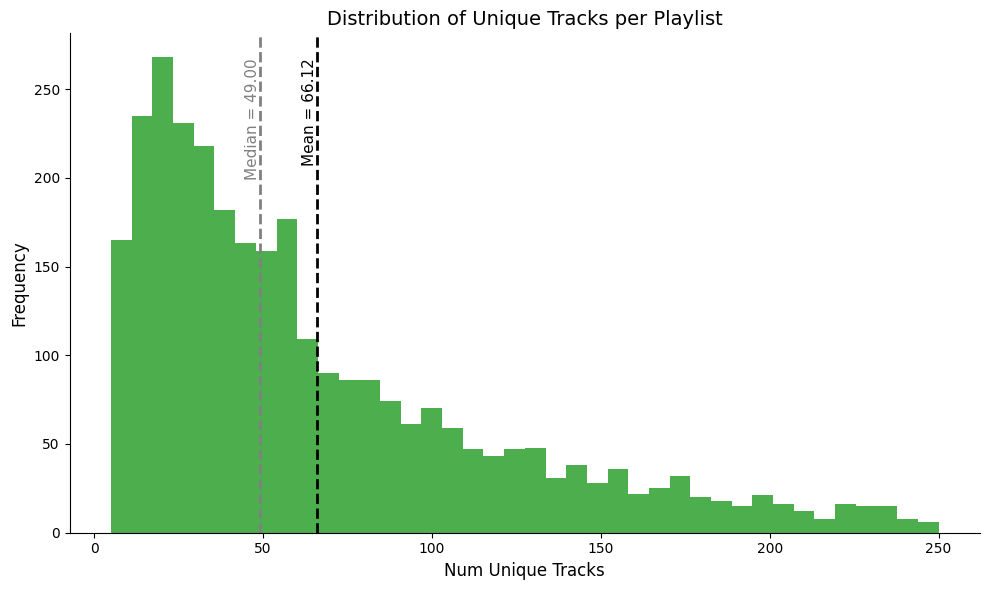

Figure saved to: plots/unique_artists.png


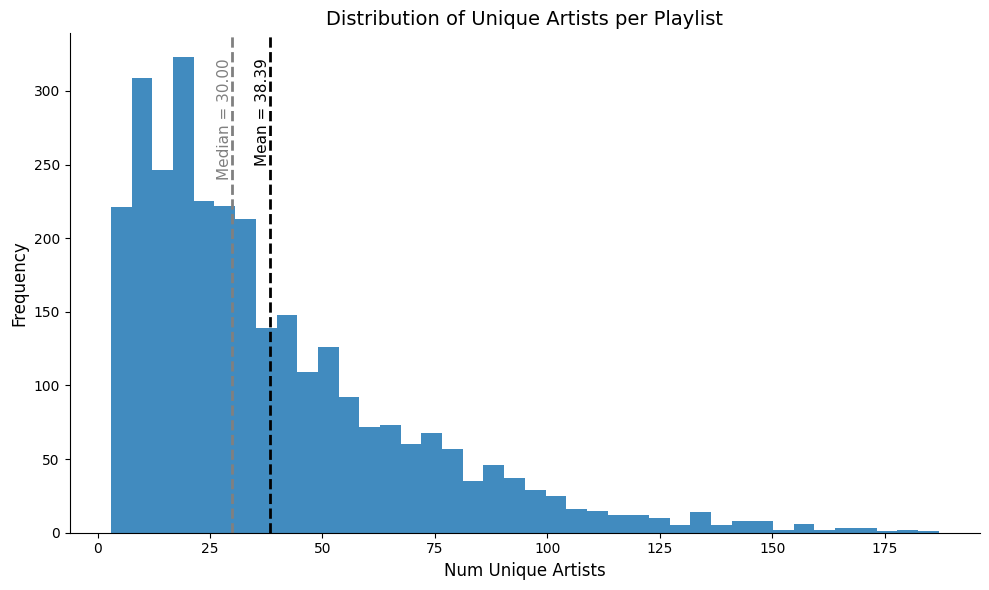

Figure saved to: plots/unique_albums.png


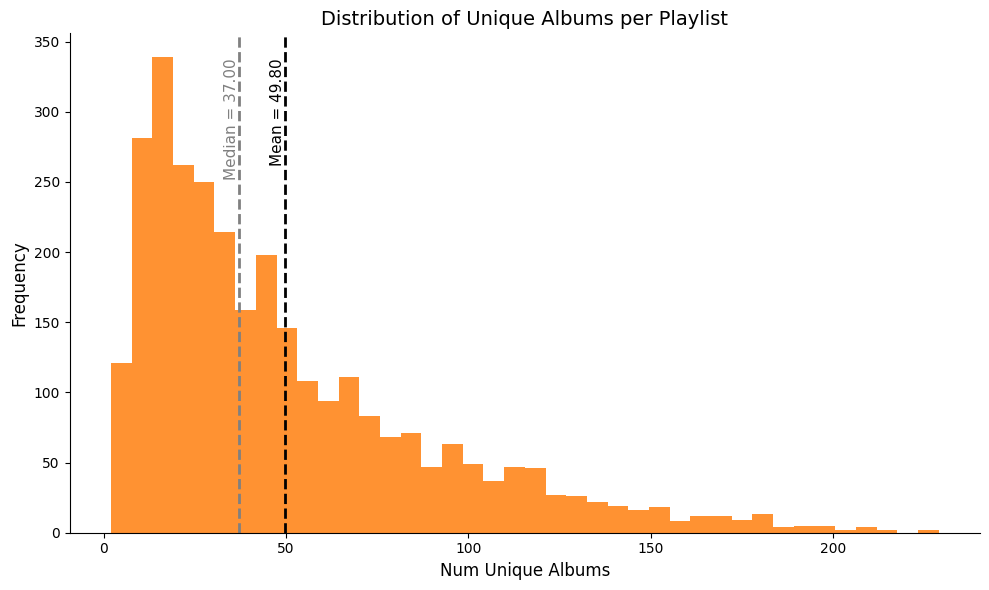

In [13]:
# --------------------------------------------------------
# df_agg must contain:
#   'num_unique_tracks'
#   'num_unique_artists'
#   'num_unique_albums'
# --------------------------------------------------------

def plot_distribution(df, column, title, color, save_path):
    """
    Plots a clean histogram for df[column] including:
      - no gridlines
      - minimalistic style
      - vertical line marking the mean
    """

    values = df[column].dropna()

    plt.style.use("default")
    fig, ax = plt.subplots(figsize=(10, 6))

    # Histogram
    ax.hist(
        values,
        bins=40,
        alpha=0.85,
        color=color
    )

    # Compute and draw mean indicator
    mean_val = values.mean()
    ax.axvline(mean_val, color="black", linestyle="--", linewidth=2)
    ax.text(
        mean_val,
        ax.get_ylim()[1] * 0.95,
        f"Mean = {mean_val:.2f}",
        rotation=90,
        verticalalignment="top",
        horizontalalignment="right",
        fontsize=11,
        color="black"
    )
      # Compute and draw median indicator
    median_val = values.median()
    ax.axvline(median_val, color="grey", linestyle="--", linewidth=2)
    ax.text(
        median_val,
        ax.get_ylim()[1] * 0.95,
        f"Median = {median_val:.2f}",
        rotation=90,
        verticalalignment="top",
        horizontalalignment="right",
        fontsize=11,
        color="grey"
    )

    # Clean visualization aesthetics
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_xlabel(column.replace("_", " ").title(), fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.set_title(title, fontsize=14)

    plt.tight_layout()
    
    # Save figure if a path is specified
    if save_path is not None:
        # Ensure directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Figure saved to: {save_path}")
    plt.show()


# --------------------------------------------------------
# Generate the 3 separate plots
# --------------------------------------------------------

plot_distribution(
    df_agg,
    "num_unique_tracks",
    "Distribution of Unique Tracks per Playlist",
    "#2ca02c",   # green
    save_path="plots/unique_tracks.png"

)

plot_distribution(
    df_agg,
    "num_unique_artists",
    "Distribution of Unique Artists per Playlist",
    "#1f77b4",   # blue
    save_path="plots/unique_artists.png"
)

plot_distribution(
    df_agg,
    "num_unique_albums",
    "Distribution of Unique Albums per Playlist",
    "#ff7f0e",   # orange
    save_path="plots/unique_albums.png"

)


In [14]:
df_agg, extras = compute_playlist_aggregates(df_full)
#df_agg.to_excel("playlist_aggregates.xlsx")


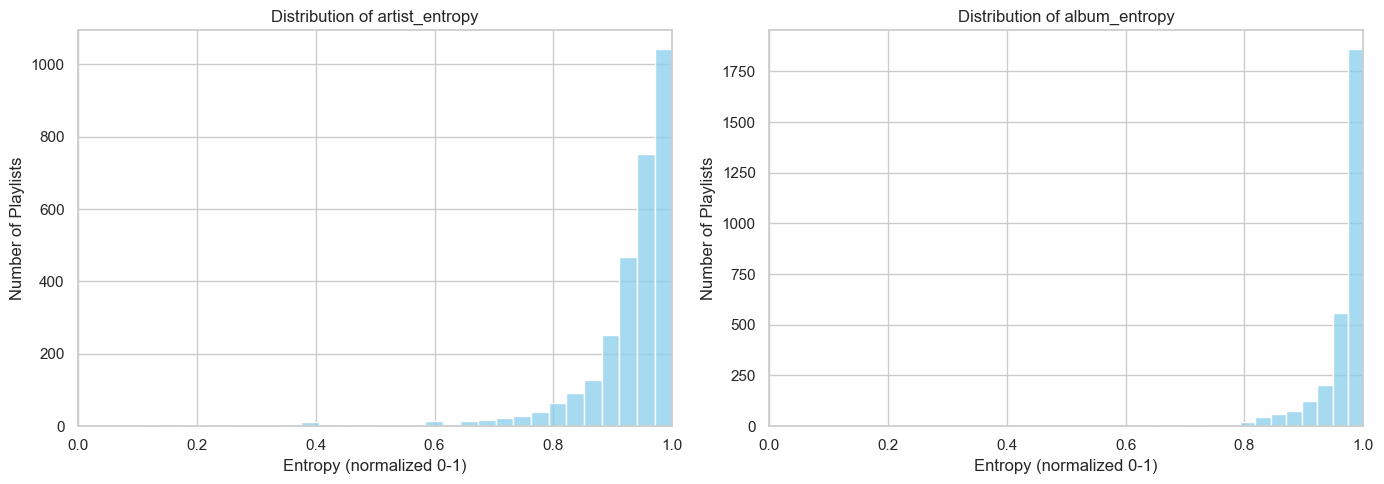

In [15]:
sns.set(style="whitegrid")

entropy_cols = ['artist_entropy', 'album_entropy']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col in zip(axes, entropy_cols):
    sns.histplot(df_agg[col], bins=30, ax=ax, color='skyblue')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('Entropy (normalized 0-1)')
    ax.set_ylabel('Number of Playlists')
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

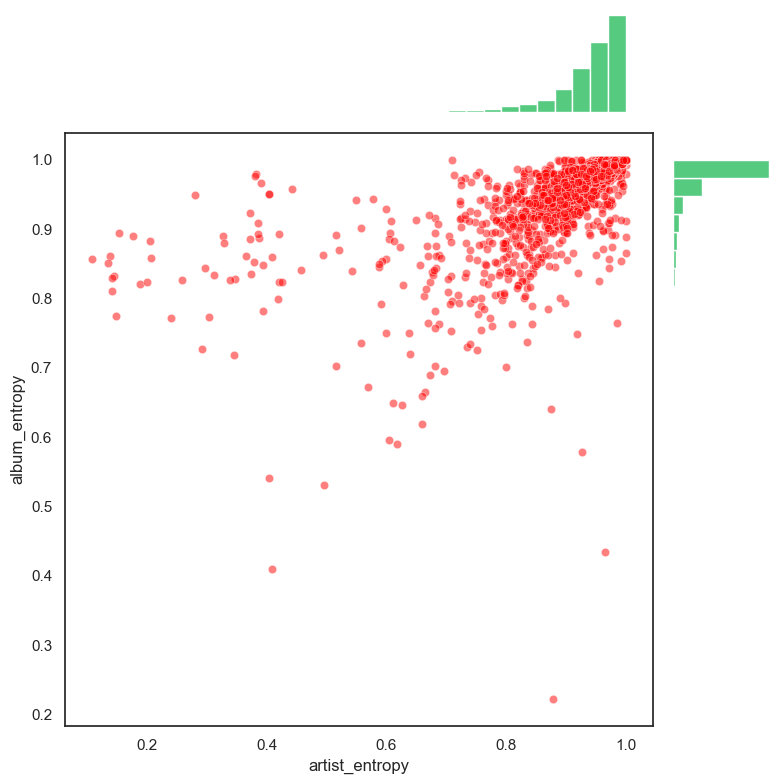

In [16]:

# Turn OFF grid globally
sns.set(style="white", rc={"axes.grid": False})

g = sns.jointplot(
    data=df_agg,
    x="artist_entropy",
    y="album_entropy",
    kind="scatter",
    color="red",
    alpha=0.5,
    marginal_kws=dict(bins=30, fill=True, color="#1DB954"),
    height=8
)

# Keep spines for joint plot (scatter)
joint_ax = g.ax_joint

for spine in ["top", "right", "left", "bottom"]:
    joint_ax.spines[spine].set_visible(True)

# Remove spines for marginal plots only
for ax in [g.ax_marg_x, g.ax_marg_y]:
    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(False)

plt.show()
g.fig.savefig("plots/entropy.png", dpi=150, bbox_inches="tight")

**First observations**

From the above, we can already observe that artist and album entropy is high in the extracted dataset, suggesting that playlists contain tracks from a wide variety of artists and albums in most cases. 

# Investigate Extras data

In [17]:
extras['top_artists'][0]

[('Jesse McCartney', 4),
 ('Chris Brown', 3),
 ('Justin Bieber', 3),
 ("Destiny's Child", 2),
 ('Beyoncé', 2)]

In [18]:
# Flatten top_artists into a long table
records = []
for pid, artist_list in extras['top_artists'].items():
    for rank, (artist_name, count) in enumerate(artist_list, start=1):
        records.append({
            "pid": pid,
            "artist_name": artist_name,
            "count_in_playlist": count,
            "rank_in_playlist": rank
        })
df_top_artists = pd.DataFrame(records)

**Investigate artist-artist co-occurence**

In [19]:
pair_counts = Counter()

for pid, group in df_top_artists.groupby("pid"):
    artists = sorted(set(group["artist_name"].dropna()))
    for a, b in combinations(artists, 2):
        pair_counts[(a, b)] += 1

df_artist_pairs = (
    pd.DataFrame(
        [
            {"artist_a": a, "artist_b": b, "num_playlists_together": cnt}
            for (a, b), cnt in pair_counts.items()
        ]
    )
    .sort_values("num_playlists_together", ascending=False)
)

In [20]:
df_artist_pairs

,artist_a,artist_b,num_playlists_together
593,Drake,Kanye West,51
594,Drake,Kendrick Lamar,46
3137,Drake,Future,39
2035,Drake,The Weeknd,33
1174,Drake,Rihanna,31
...,...,...,...
8981,James Blake,Janelle Monáe,1
8980,Dj Bitman,Trüby Trio,1
8979,Dj Bitman,Janelle Monáe,1
8978,Dj Bitman,James Blake,1


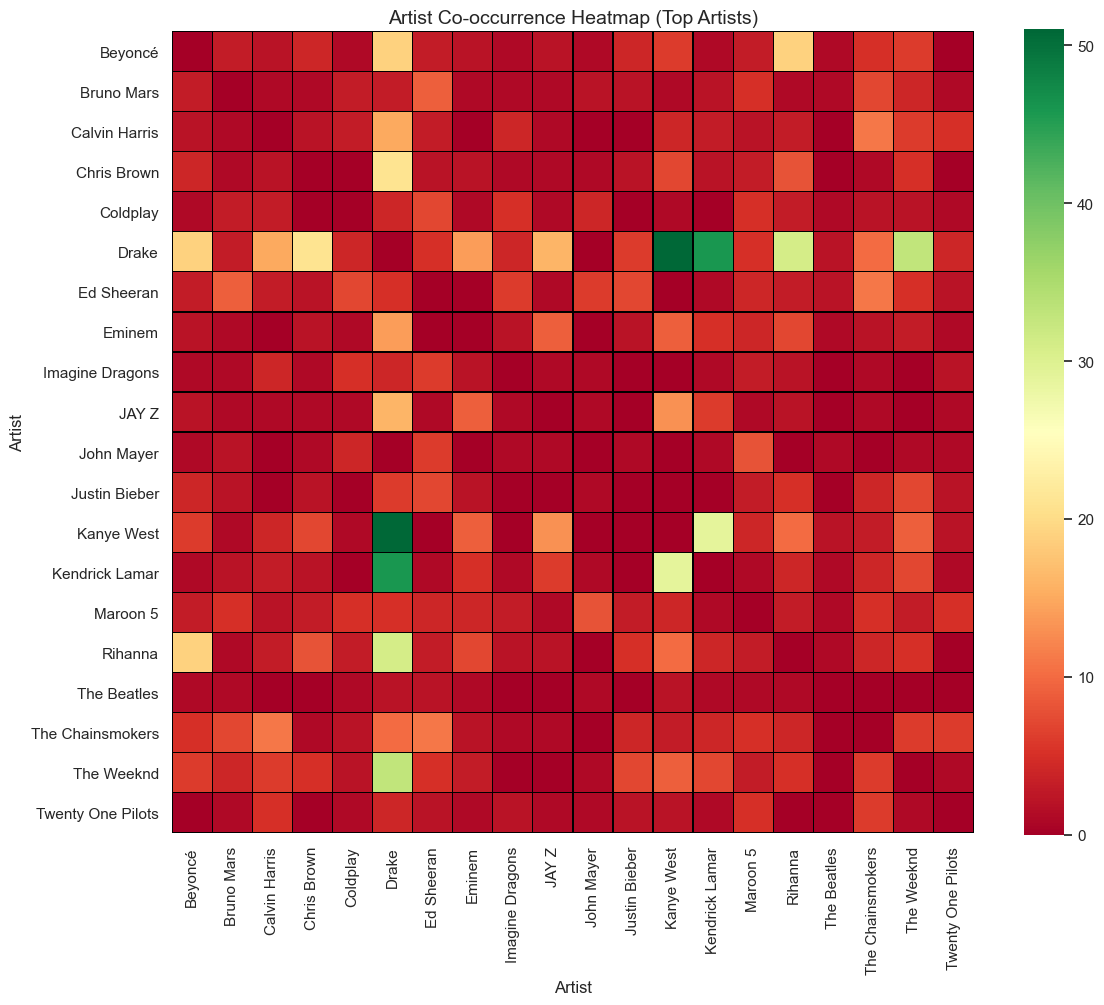

In [21]:
# Get top 10 artists by total co-occurrence
top_artists = pd.Series(df_artist_pairs["artist_a"]
                        .tolist() + df_artist_pairs["artist_b"].tolist()
                           ).value_counts().head(20).index.tolist()

# Filter to those pairs
mask = df_artist_pairs["artist_a"].isin(top_artists) & df_artist_pairs["artist_b"].isin(top_artists)
df_pairs_small = df_artist_pairs[mask]

# Build matrix
artists_sorted = sorted(top_artists)
matrix = pd.DataFrame(0, index=artists_sorted, columns=artists_sorted, dtype=int) 

for _, row in df_pairs_small.iterrows():
    a, b, w = row["artist_a"], row["artist_b"], row["num_playlists_together"]
    matrix.loc[a, b] = w #diagonal will stay 0 to not disrupt the outcome (we want to show significant co-occurences and not those created by construction)
    matrix.loc[b, a] = w

plt.figure(figsize=(12, 10))

sns.heatmap(
    matrix,
    cmap="RdYlGn",        
    linewidths=0.2,       # thin gridlines 
    linecolor="black",    # makes cells clearer
    square=True
)

plt.title("Artist Co-occurrence Heatmap (Top Artists)", fontsize=14)
plt.xlabel("Artist", fontsize=12)
plt.ylabel("Artist", fontsize=12)
plt.tight_layout()
plt.savefig("plots/co_occurences_heatmap.png")
plt.show()


In [22]:
# Merge top artists with playlist-level entropies
df_artist_playlists = (df_top_artists
    .merge(
        df_agg[["artist_entropy", "album_entropy"]],
        left_on="pid",
        right_index=True,
        how="left",
    )
)

# Aggregate per artist
df_artist_summary = (
    df_artist_playlists
    .groupby("artist_name")
    .agg(
        n_playlists=("pid", "nunique"),
        avg_rank=("rank_in_playlist", "mean"),
        avg_artist_entropy=("artist_entropy", "mean"),
        avg_album_entropy=("album_entropy", "mean"),
    )
    .sort_values("n_playlists", ascending=False)
)


In [ ]:
df_artist_summary.head()

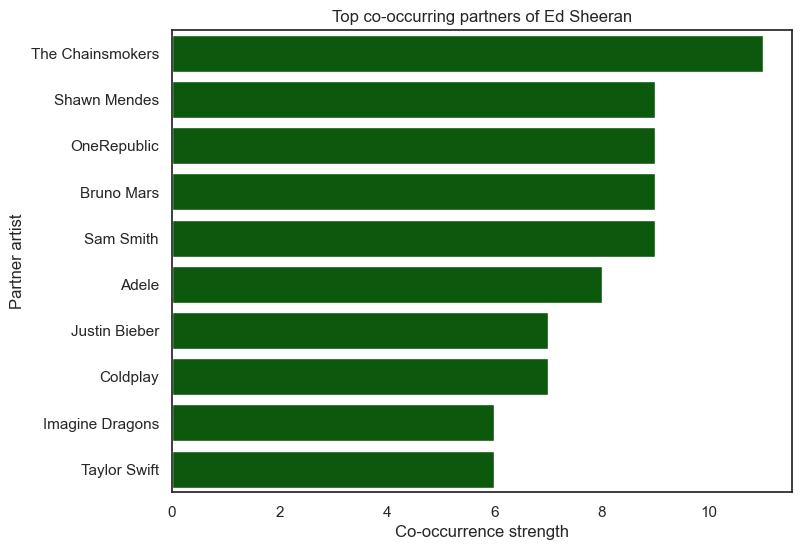

In [23]:
df_pairs_long = pd.concat([
    df_artist_pairs.rename(columns={"artist_a": "artist", "artist_b": "partner"}),
    df_artist_pairs.rename(columns={"artist_b": "artist", "artist_a": "partner"})
], ignore_index=True)

df_artist_co_stats = (
    df_pairs_long
    .groupby("artist")
    .agg(
        num_distinct_partners=("partner", "nunique"),
        total_pair_strength=("num_playlists_together", "sum"),
        strongest_single_pair=("num_playlists_together", "max")
    )
    .sort_values("total_pair_strength", ascending=False)
)


#Focus on specific artists
target_artist = "Ed Sheeran"   # example — replace with any artist name

df_drake_partners = (
    df_pairs_long
    .query("artist == @target_artist")
    .sort_values("num_playlists_together", ascending=False)
)

df_drake_partners.head()
plt.figure(figsize=(8,6))
sns.barplot(
    data=df_drake_partners.head(10),
    x="num_playlists_together",
    y="partner",
    color="darkgreen"
)
plt.title(f"Top co-occurring partners of {target_artist}")
plt.xlabel("Co-occurrence strength")
plt.ylabel("Partner artist")
plt.show()

# Question 3 - similarity between tracks

In [19]:
# ------------------------------------------------------------------
# Build a simple track feature table including genre
# ------------------------------------------------------------------

df_track_features = (
    df_full_enriched
    .dropna(subset=["track_uri"])
    .drop_duplicates(subset=["track_uri"])
    [["track_uri", "artist_uri", "album_uri", "duration_ms_track",
      "track_name", "artist_name", "album_name", "genre"]]   # <-- CHANGED HERE
    .set_index("track_uri")
)

# Convert genre strings into clean lists
df_track_features["genre"] = (
    df_track_features["genre"]
    .fillna("")
    .apply(lambda g: [x.strip().lower() for x in g.split(",") if x.strip()])
)

def _get_track_info(track_id: str):
    return df_track_features.loc[track_id]

def genre_similarity(genres1, genres2):
    """
    Jaccard similarity over genre lists.
    Returns None if either has no genre, so genre is ignored.
    """
    if not genres1 or not genres2:
        return None

    set1, set2 = set(genres1), set(genres2)
    inter = len(set1 & set2)
    union = len(set1 | set2)

    if union == 0:
        return None

    return inter / union

import numpy as np

def metadata_similarity(track_id_1: str,
                        track_id_2: str,
                        max_duration_diff_sec: float = 150.0) -> float:

    if track_id_1 == track_id_2:
        return 1.0

    try:
        t1 = _get_track_info(track_id_1)
        t2 = _get_track_info(track_id_2)
    except KeyError:
        return 0.0

    # Artist and album match
    same_artist = 1.0 if t1["artist_uri"] == t2["artist_uri"] else 0.0
    same_album  = 1.0 if t1["album_uri"]  == t2["album_uri"]  else 0.0

    # Duration similarity (smooth exponential)
    d1 = (t1["duration_ms_track"] or 0) / 1000.0
    d2 = (t2["duration_ms_track"] or 0) / 1000.0
    diff = abs(d1 - d2)
    duration_closeness = float(np.exp(-diff / max_duration_diff_sec))

    # GENRE similarity from 'genre' column
    s_genre = genre_similarity(t1["genre"], t2["genre"])

    # Base weights
    weights = {
        "genre": 0.40,
        "artist": 0.30,
        "album": 0.15,
        "duration": 0.15,
    }

    # If genre missing, remove weight and renormalize
    if s_genre is None:
        del weights["genre"]
        total = sum(weights.values())
        for k in weights:
            weights[k] /= total

    # Combine components
    sim = (
        (weights.get("genre", 0) * (s_genre if s_genre is not None else 0)) +
        (weights["artist"] * same_artist) +
        (weights["album"] * same_album) +
        (weights["duration"] * duration_closeness)
    )

    return float(max(0.0, min(1.0, sim)))



In [20]:
from collections import defaultdict

track_to_playlists = defaultdict(set)

for _, row in df_full[["track_uri", "pid"]].dropna(subset=["track_uri"]).iterrows():
    track_to_playlists[row["track_uri"]].add(row["pid"])

TOTAL_PLAYLISTS = len(df_full["pid"].unique())


def collaborative_similarity(track_id_1: str, track_id_2: str) -> float:
    """
    Collaborative similarity using normalized PMI.
    """
    if track_id_1 == track_id_2:
        return 1.0

    P1 = track_to_playlists.get(track_id_1, set())
    P2 = track_to_playlists.get(track_id_2, set())

    if not P1 or not P2:
        return 0.0

    inter = len(P1 & P2)
    if inter == 0:
        return 0.0

    p_ab = inter / TOTAL_PLAYLISTS
    p_a = len(P1) / TOTAL_PLAYLISTS
    p_b = len(P2) / TOTAL_PLAYLISTS

    pmi = math.log(p_ab / (p_a * p_b))

    sim = 1 / (1 + math.exp(-pmi))
    return float(sim)


In [21]:
def track_similarity(track_id_1: str,
                     track_id_2: str,
                     alpha: float = 0.55) -> float:
    """
    Final similarity combining metadata + PMI collaborative similarity.
    """
    s_meta = metadata_similarity(track_id_1, track_id_2)
    s_collab = collaborative_similarity(track_id_1, track_id_2)

    sim = alpha * s_meta + (1 - alpha) * s_collab
    return float(max(0.0, min(1.0, sim)))

In [22]:
subset_track_ids = df_track_features.index[:20].tolist()

similarity_matrix = pd.DataFrame(index=subset_track_ids,
                                 columns=subset_track_ids,
                                 dtype=float)
start_time = time.time()

for t1 in subset_track_ids:
    for t2 in subset_track_ids:
        similarity_matrix.loc[t1, t2] = track_similarity(t1, t2)
end_time = time.time()
elapsed = end_time - start_time
print(elapsed)
        
labels = (df_track_features["track_name"] + " — " + df_track_features["artist_name"]).to_dict()
similarity_matrix = similarity_matrix.rename(index=labels, columns=labels)

similarity_matrix.to_excel("sim_matrix.xlsx")
similarity_matrix.head()


0.11562681198120117


,Lose Control (feat. Ciara & Fat Man Scoop) — Missy Elliott,Toxic — Britney Spears,Crazy In Love — Beyoncé,Rock Your Body — Justin Timberlake,It Wasn't Me — Shaggy,Yeah! — Usher,My Boo — Usher,Buttons — The Pussycat Dolls,Say My Name — Destiny's Child,Hey Ya! - Radio Mix / Club Mix — OutKast,Promiscuous — Nelly Furtado,Right Where You Want Me - Radio Edit Version — Jesse McCartney,Beautiful Soul — Jesse McCartney,Leavin' — Jesse McCartney,Me & U — Cassie,Ice Box — Omarion,Sk8er Boi — Avril Lavigne,Run It! — Chris Brown,Check On It - feat. Bun B and Slim Thug — Beyoncé,"Jumpin', Jumpin' — Destiny's Child"
Lose Control (feat. Ciara & Fat Man Scoop) — Missy Elliott,1.000000,0.544908,0.560673,0.699301,0.554653,0.536548,0.723969,0.738680,0.529777,0.560500,0.726297,0.563727,0.543830,0.710032,0.696067,0.547267,0.546633,0.740318,0.550196,0.571368
Toxic — Britney Spears,0.544908,1.000000,0.533877,0.513449,0.509723,0.501415,0.474097,0.553447,0.508643,0.505836,0.524576,0.565342,0.540665,0.551994,0.553819,0.512634,0.540875,0.534005,0.553561,0.491276
Crazy In Love — Beyoncé,0.560673,0.533877,1.000000,0.539255,0.526429,0.543369,0.522871,0.557566,0.530075,0.556152,0.542851,0.550230,0.538825,0.540679,0.520433,0.523167,0.512621,0.559987,0.805003,0.542678
Rock Your Body — Justin Timberlake,0.699301,0.513449,0.539255,1.000000,0.528880,0.550925,0.711295,0.713096,0.557152,0.527905,0.716337,0.529293,0.499411,0.675438,0.707424,0.554859,0.520806,0.704070,0.526633,0.538017
It Wasn't Me — Shaggy,0.554653,0.509723,0.526429,0.528880,1.000000,0.530808,0.558312,0.534461,0.518751,0.538068,0.539859,0.531767,0.493886,0.505375,0.529777,0.541488,0.516301,0.563466,0.488203,0.552965


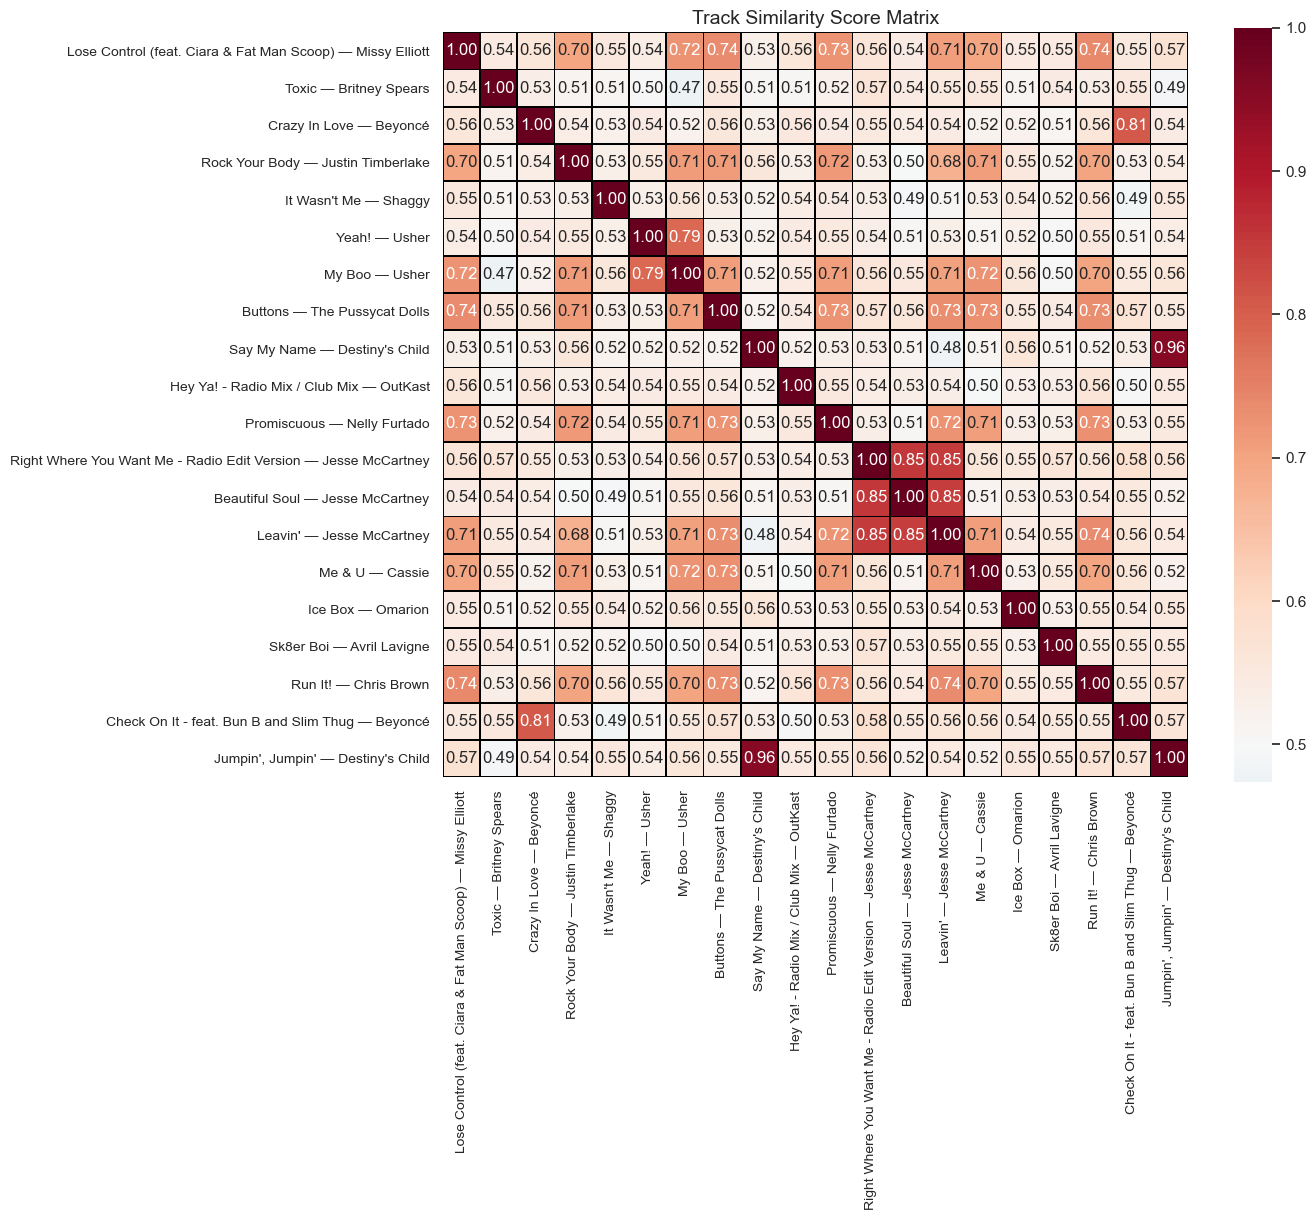

In [29]:

plt.figure(figsize=(14, 12))

sns.heatmap(
    similarity_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",    
    center=0.5,        # anchor midpoint around 0.5 similarity
    linewidths=0.5,
    linecolor="black",
    square=True
)

plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.title("Track Similarity Score Matrix", fontsize=14)
plt.tight_layout()
plt.savefig("plots/similarity_matrix_excelstyle.png", dpi=300)
plt.show()


# Question 4 - Similarity between playlists

**Standard approach**

In [24]:
from tqdm import tqdm

# Build dictionary: playlist → set of track_ids
playlist_tracks = (
    df_full.groupby("pid")["track_id"]
           .apply(set)
           .to_dict()
)

def jaccard(a, b):
    """Compute Jaccard similarity between two sets."""
    inter = len(a & b)
    union = len(a | b)
    if union == 0:
        return 0.0
    return inter / union


def compute_jaccard_all(playlists_dict, sample_fraction=0.01):
    """
    Compute Jaccard similarity for all playlist pairs
    but only using a sample_fraction of playlists for speed.
    """
    pids = list(playlists_dict.keys())
    sample_size = int(len(pids) * sample_fraction)
    pids_sample = pids[:sample_size]

    results = {}

    for pid in tqdm(pids_sample):
        A = playlists_dict[pid]

        sims = []
        for other_pid in pids_sample:
            if pid == other_pid:
                continue
            score = jaccard(A, playlists_dict[other_pid])
            sims.append((other_pid, score))

        sims_sorted = sorted(sims, key=lambda x: x[1], reverse=True)
        results[pid] = sims_sorted[:4]

    return results




In [25]:
jaccard_results = compute_jaccard_all(playlist_tracks)


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 5516.89it/s]


In [26]:
for pid, sims in list(jaccard_results.items())[:2]:
    print(f"\nPlaylist {pid}:")
    for other, score in sims:
        print(f"  Similar Playlist {other} - Jaccard: {score:.4f}")


Playlist 0:
  Similar Playlist 5 - Jaccard: 0.0244
  Similar Playlist 17 - Jaccard: 0.0078
  Similar Playlist 14 - Jaccard: 0.0066
  Similar Playlist 1 - Jaccard: 0.0000

Playlist 1:
  Similar Playlist 14 - Jaccard: 0.0071
  Similar Playlist 0 - Jaccard: 0.0000
  Similar Playlist 2 - Jaccard: 0.0000
  Similar Playlist 3 - Jaccard: 0.0000


**Dask Approach**

In [34]:
import dask.bag as db
client = Client()  # you can pass processes=False for threads only
client


C:\Users\Clara\anaconda3\lib\site-packages\distributed\dashboard\core.py:18: UserWarning: 
Dask needs bokeh!=3.0.*,>=2.4.2 for the dashboard.
You have bokeh=2.3.2.
Continuing without the dashboard.
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 15.93 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56397,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.93 GiB
Comm: tcp://127.0.0.1:56416,Total threads: 4
Dashboard: http://127.0.0.1:56420/status,Memory: 3.98 GiB
Nanny: tcp://127.0.0.1:56400,


In [35]:
# 2.1 Build: pid -> set(track_id)
playlist_tracks_full = (
    df_full.groupby("pid")["track_id"]
           .apply(set)
           .to_dict()
)

print(f"Total playlists in df_full: {len(playlist_tracks_full)}")

# 2.2 Sample some playlists for similarity computation
SAMPLE_FRACTION = 0.01   # 1% like in your text
MIN_PLAYLISTS   = 500    # just to ensure we still have a reasonable number

all_pids = list(playlist_tracks_full.keys())
sample_size = max(int(len(all_pids) * SAMPLE_FRACTION), MIN_PLAYLISTS)

sample_pids = all_pids[:sample_size]  # or random.sample(all_pids, sample_size)

print(f"Using {len(sample_pids)} playlists for Dask similarity (sample)")


Total playlists in df_full: 3000
Using 500 playlists for Dask similarity (sample)


In [36]:
# pid -> set(track_id) restricted to the sample
playlist_tracks = {pid: playlist_tracks_full[pid] for pid in sample_pids}


In [37]:
def jaccard(set_a, set_b):
    """Compute Jaccard similarity between two sets of track IDs."""
    inter = len(set_a & set_b)
    union = len(set_a | set_b)
    if union == 0:
        return 0.0
    return inter / union


In [38]:
# Scatter the small playlist_tracks dict to workers
playlist_tracks_future = client.scatter(playlist_tracks, broadcast=True)

# We also keep a simple list of PIDs that every task will compare against
pids_all = list(playlist_tracks.keys())


In [39]:
def compute_top_k_for_pid(pid, playlist_tracks, pids_all, k=4):
    """
    Compute the top-k most similar playlists for a single playlist ID, 
    using Jaccard similarity.
    
    Parameters:
    - pid: the playlist ID to compare
    - playlist_tracks: dict pid -> set(track_id)
    - pids_all: list of all playlist IDs considered
    - k: number of neighbors to return
    
    Returns:
    - (pid, [(other_pid, score), ...]) sorted by descending score
    """
    tracks_a = playlist_tracks[pid]
    sims = []

    for other_pid in pids_all:
        if other_pid == pid:
            continue
        tracks_b = playlist_tracks[other_pid]
        score = jaccard(tracks_a, tracks_b)
        sims.append((other_pid, score))

    sims.sort(key=lambda x: x[1], reverse=True)
    return pid, sims[:k]


In [41]:
# Build a Dask bag over the sampled PIDs
bag = db.from_sequence(sample_pids, npartitions=8)

# Map the compute function over all PIDs
# NOTE: we pass `playlist_tracks_future` and `pids_all` as arguments
dask_results = bag.map(
    compute_top_k_for_pid,
    playlist_tracks=playlist_tracks_future,
    pids_all=pids_all,
    k=4
).compute()


In [42]:
rows = []
for pid, neighbors in dask_results:
    for other_pid, score in neighbors:
        rows.append({
            "pid": pid,
            "similar_pid": other_pid,
            "jaccard_score": score
        })

df_jaccard_dask = pd.DataFrame(rows)

df_jaccard_dask.head(20)


,pid,similar_pid,jaccard_score
0,0,262,0.115607
1,0,38,0.083333
2,0,355,0.080357
3,0,380,0.064706
4,1,343,0.060606
5,1,45,0.055046
6,1,243,0.051948
7,1,374,0.045455
8,2,88,0.065574
9,2,238,0.011765


In [45]:
def print_top_similar(df_results, target_pid, top_k=4):
    df_sub = (
        df_results[df_results["pid"] == target_pid]
        .sort_values("jaccard_score", ascending=False)
        .head(top_k)
    )
    if df_sub.empty:
        print(f"No similarity results found for playlist {target_pid}")
        return
    
    print(f"\nPlaylist {target_pid}:")
    for _, row in df_sub.iterrows():
        print(f"  Similar Playlist {int(row['similar_pid'])} - "
              f"Jaccard Similarity: {row['jaccard_score']:.4f}")


# Example (if 1 and 102 are in your sample_pids)
print_top_similar(df_jaccard_dask, 1, top_k=4)
print_top_similar(df_jaccard_dask, 102, top_k=4)



Playlist 1:
  Similar Playlist 343 - Jaccard Similarity: 0.0606
  Similar Playlist 45 - Jaccard Similarity: 0.0550
  Similar Playlist 243 - Jaccard Similarity: 0.0519
  Similar Playlist 374 - Jaccard Similarity: 0.0455

Playlist 102:
  Similar Playlist 306 - Jaccard Similarity: 0.1159
  Similar Playlist 335 - Jaccard Similarity: 0.0862
  Similar Playlist 454 - Jaccard Similarity: 0.0733
  Similar Playlist 285 - Jaccard Similarity: 0.0500


In [ ]:
client.close()

In [48]:
# df_jaccard_dask must exist from earlier steps
# Columns expected: "pid", "similar_pid", "jaccard_score"

# Pivot into playlist x playlist similarity matrix
similarity_matrix = df_jaccard_dask.pivot_table(
    index="pid",
    columns="similar_pid",
    values="jaccard_score",
    fill_value=0
)

similarity_matrix.head()


similar_pid,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,498,499
pid,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
#Chose most popular visualisation based on those that appear most often
top_pids = (
    df_jaccard_dask["pid"]
    .value_counts()
    .head(100)
    .index
)

sim_sub = similarity_matrix.iloc[top_pids, top_pids]



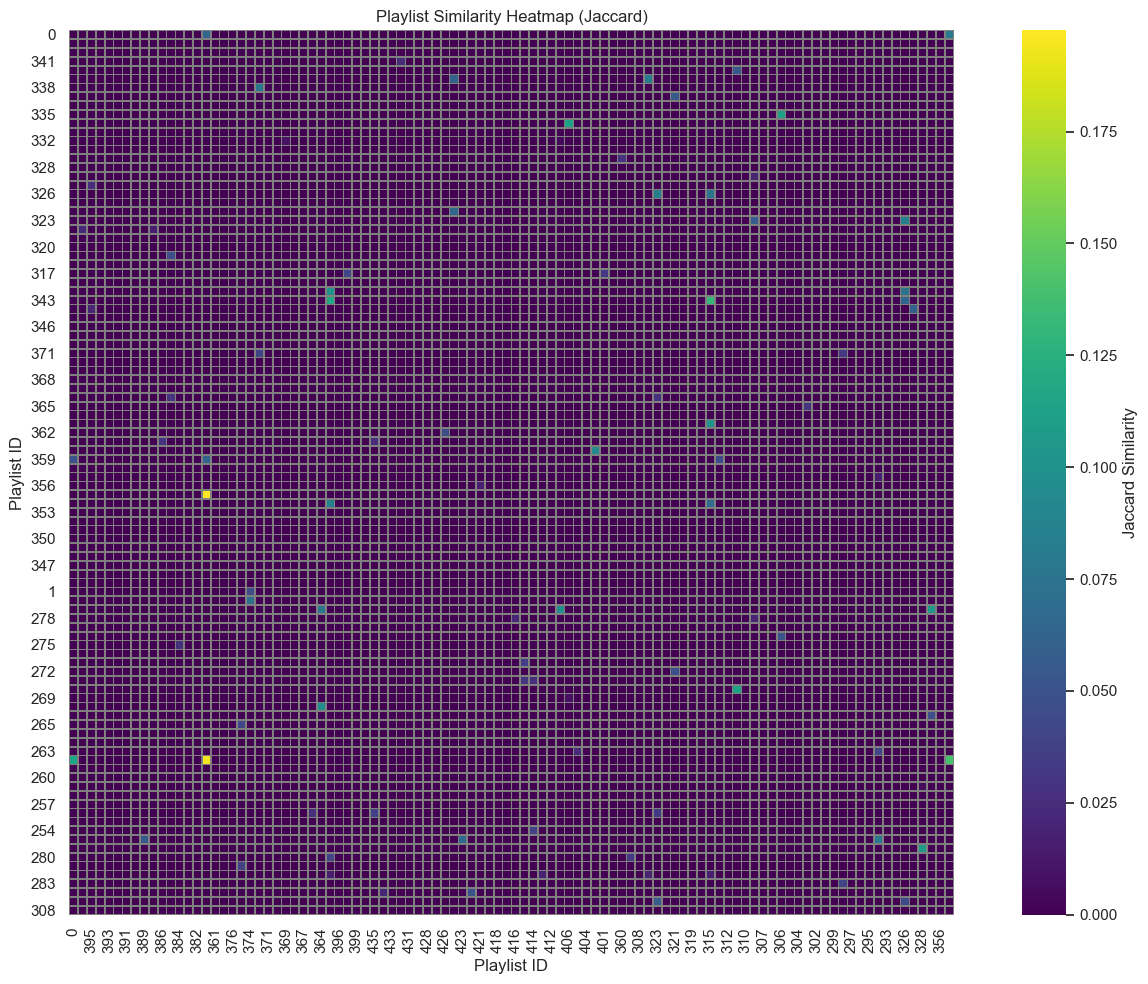

In [54]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    sim_sub,
    cmap="viridis",
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar_kws={"label": "Jaccard Similarity"}
)

plt.title("Playlist Similarity Heatmap (Jaccard)")
plt.xlabel("Playlist ID")
plt.ylabel("Playlist ID")
plt.tight_layout()
plt.show()


# Question 5 - Playlist continuation

In [27]:
# Set of all unique tracks in the dataset and dictionary mapping each pid to the set of its tracks
tracks_all = set(df_full['track_uri'].unique())
playlists_all = df_full.groupby('pid')['track_uri'].apply(lambda x: set(x.unique())).to_dict()

# Metadata similarity between two tracks
def track_similarity(track1, track2):
    return metadata_similarity(track1, track2)

# Jaccard similarity between two playlists
def playlist_similarity(pid1, pid2):
    return len(pid1 & pid2)/len(pid1 | pid2)

# Content-based recommendation using similarity between tracks
def content_based_recommendation(playlist_ref, p=1):
    n = len(playlist_ref)
    norm_1n = np.linalg.norm(np.ones(n), ord=p)

    # Content-based score for each candidate track
    scores = []
    for track in tracks_all - playlist_ref:
        v = np.array([track_similarity(track, track_ref) for track_ref in playlist_ref])
        score = np.linalg.norm(v, ord=p) / norm_1n
        scores.append((track, score))

    scores.sort(key=lambda x: x[1], reverse=True)
    return scores

# User-based recommendation using similarity between playlists
def user_based_recommendation(playlist_ref, k=50, p=1):
    norm_1k = np.linalg.norm(np.ones(k), ord=p)

    # Similarities between reference playlist and all playlists
    similarities = [(pid, playlist_similarity(playlists_all[pid], playlist_ref)) for pid in playlists_all.keys()]
    similarities.sort(key=lambda x: x[1], reverse=True)
    top_k = similarities[:k]

    # Tracks from the top-k most similar playlists, except those already present in the playlist
    candidate_tracks = set()
    for pid, _ in top_k:
        candidate_tracks.update(playlists_all[pid])
    candidate_tracks = candidate_tracks - playlist_ref

    # User-based score for each candidate track
    scores = []
    for track in candidate_tracks:
        w = np.array([playlist_similarity(playlists_all[pid], playlist_ref) if track in playlists_all[pid] else 0 for pid, _ in top_k])
        score = np.linalg.norm(w, ord=p) / norm_1k
        scores.append((track, score))
    
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores

# Hybrid-based recommendation using both similarity between tracks and playlists
def hybrid_recommendation(playlist_ref, a=1, b=1, k=50, p=1):
    n = len(playlist_ref)
    norm_1n = np.linalg.norm(np.ones(n), ord=p)
    norm_1k = np.linalg.norm(np.ones(k), ord=p)

    # Tracks from the top-k most similar playlists, except those already present in the playlist
    similarities = [(pid, playlist_similarity(playlists_all[pid], playlist_ref)) for pid in playlists_all.keys()]
    similarities.sort(key=lambda x: x[1], reverse=True)
    top_k = similarities[:k]
    candidate_tracks = set()
    for pid, _ in top_k:
        candidate_tracks.update(playlists_all[pid])
    candidate_tracks = candidate_tracks - playlist_ref

   # Hybrid score for each candidate track
    scores = []
    for track in candidate_tracks:
        v = np.array([track_similarity(track, track_ref) for track_ref in playlist_ref])
        score_content = np.linalg.norm(v, ord=p) / norm_1n
        w = np.array([playlist_similarity(playlists_all[pid], playlist_ref) if track in playlists_all[pid] else 0 for pid, _ in top_k])
        score_user = np.linalg.norm(w, ord=p) / norm_1k
        scores.append((track, a*score_content+b*score_user))
    
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores

We select one playlist to use as our test playlist.

In [28]:
test = playlists_all[12]
test_list = list(test)
[(df_tracks.loc[df_tracks['track_uri'] == test_list[n], 'track_name'].iloc[0],
  df_tracks.loc[df_tracks['track_uri'] == test_list[n], 'album_name'].iloc[0]) for n in range(len(test))]

[("I Know There's Gonna Be (Good Times) [feat. Popcaan]",
  "I Know There's Gonna Be (Good Times) [feat. Popcaan]"),
 ('Stolen Dance', 'Sadnecessary'),
 ('Scars To Your Beautiful', 'Know-It-All'),
 ('New Soul', 'Yael Naim'),
 ('Hold Back The River', 'Chaos And The Calm'),
 ('So High (feat. Ghost Loft)', 'Blacc Hollywood'),
 ("It's Not Unusual", 'Along Came Tom Jones'),
 ('Are You With Me - Radio Edit', 'Less Is More'),
 ('Let Her Go', 'All The Little Lights')]

Using the content-based method, we get the following recommendations.

In [29]:
result_content = content_based_recommendation(test)
[(df_tracks.loc[df_tracks['track_uri'] == result_content[n][0], 'track_name'].iloc[0],
  df_tracks.loc[df_tracks['track_uri'] == result_content[n][0], 'album_name'].iloc[0]) for n in range(10)]

[('All the Little Lights', 'All The Little Lights'),
 ("I'm Yours", 'Know-It-All'),
 ('Craving', 'Chaos And The Calm'),
 ('Stone', 'Know-It-All'),
 ('When We Were On Fire', 'Chaos And The Calm'),
 ('The Wrong Direction', 'All The Little Lights'),
 ('Stars', 'Know-It-All'),
 ('Seventeen', 'Know-It-All'),
 ('River Of Tears', 'Know-It-All'),
 ('Four Pink Walls', 'Know-It-All')]

Now we use the user-based method.

In [30]:
result_user = user_based_recommendation(test)
[(df_tracks.loc[df_tracks['track_uri'] == result_user[n][0], 'track_name'].iloc[0],
  df_tracks.loc[df_tracks['track_uri'] == result_user[n][0], 'album_name'].iloc[0]) for n in range(10)]

[('Closer', 'Closer'),
 ('Say Something', 'Is There Anybody Out There? - Track by Track Commentary'),
 ('Uptown Funk', 'Uptown Special'),
 ('See You Again (feat. Charlie Puth) - From "Furious 7"', 'Nine Track Mind'),
 ('Rather Be (feat. Jess Glynne)', 'I Cry When I Laugh'),
 ('All of Me', 'Love In The Future'),
 ('Side To Side', 'Dangerous Woman'),
 ('Let It Go - From "Frozen"/Soundtrack Version', 'Frozen'),
 ('Lean On (feat. MØ & DJ Snake)', 'Peace Is The Mission'),
 ('Take Me To Church', 'Hozier')]

Let's finally use the hybrid method.

In [31]:
result_hybrid = hybrid_recommendation(test, result_user[0][1], result_content[0][1])
[(df_tracks.loc[df_tracks['track_uri'] == result_hybrid[n][0], 'track_name'].iloc[0],
  df_tracks.loc[df_tracks['track_uri'] == result_hybrid[n][0], 'album_name'].iloc[0]) for n in range(10)]

[('Closer', 'Closer'),
 ('See You Again (feat. Charlie Puth) - From "Furious 7"', 'Nine Track Mind'),
 ('Say Something', 'Is There Anybody Out There? - Track by Track Commentary'),
 ('Uptown Funk', 'Uptown Special'),
 ('Rather Be (feat. Jess Glynne)', 'I Cry When I Laugh'),
 ('Side To Side', 'Dangerous Woman'),
 ('Stayin Out All Night', 'Blacc Hollywood'),
 ('The Wrong Direction', 'All The Little Lights'),
 ('Location', 'American Teen'),
 ('Take Me To Church', 'Hozier')]

We can now compare the number of common tracks between the three methods:

In [32]:
k = 40

topk_content = set([track for track, _ in result_content[:k]])
topk_user = set([track for track, _ in result_user[:k]])
topk_hybrid = set([track for track, _ in result_hybrid[:k]])

common_content_user = len(topk_content & topk_user)
common_hybrid_content = len(topk_hybrid & topk_content)
common_hybrid_user = len(topk_hybrid & topk_user)

print(f"Number of recommended tracks per method: {k}")
print(f"Number of common tracks between content-based and user-based : {common_content_user}")
print(f"Number of common tracks between hybrid and content-based : {common_hybrid_content}")
print(f"Number of common tracks between hybrid and user-based : {common_hybrid_user}")

Number of recommended tracks per method: 40
Number of common tracks between content-based and user-based : 2
Number of common tracks between hybrid and content-based : 9
Number of common tracks between hybrid and user-based : 29


## Collaborative filtering

first we build an interction data set: 
playlist -> users
tracks -> items

In [ ]:
def build_interaction_dataset(df, 
                              min_tracks_per_playlist=5, 
                              min_interactions_per_track=3):
    """
    Build a playlist–track interaction dataset from the merged table.
    Similar to MPD formatting.
    
    Returns:
        df_interactions (playlist-track pairs)
        df_track_features (track-level metadata/features)
    """

    # 1. Extract interactions (playlist → track)
    df_interactions = df[["pid", "track_id", "track_name", "artist_name"]].copy()

    # Rename pid → user_id (consistent with recommender libraries)
    df_interactions = df_interactions.rename(columns={"pid": "user_id", 
                                                      "track_id": "item_id"})
    
    # Add target column (implicit feedback)
    df_interactions["target"] = 1

    # Remove missing IDs
    df_interactions = df_interactions.dropna(subset=["user_id", "item_id"])

    # 2. Filter: playlists with too few tracks
    user_counts = df_interactions["user_id"].value_counts()
    active_users = user_counts[user_counts >= min_tracks_per_playlist].index
    df_interactions = df_interactions[df_interactions["user_id"].isin(active_users)]

    # 3. Filter: tracks with too few interactions
    item_counts = df_interactions["item_id"].value_counts()
    popular_items = item_counts[item_counts >= min_interactions_per_track].index
    df_interactions = df_interactions[df_interactions["item_id"].isin(popular_items)]

    # 4. Build track feature table (content metadata)
    track_cols = [
        "track_id", "track_name", "artist_name", "artist_uri", "album_uri",
        "album_name", "duration_ms_track", "genre",
        "danceability", "energy", "valence", "tempo",
        "acousticness", "instrumentalness", "liveness"
    ]
    track_cols = [c for c in track_cols if c in df.columns]

    df_track_features = df[track_cols].drop_duplicates("track_id").set_index("track_id")

    # Clean genre → list
    if "genre" in df_track_features.columns:
        df_track_features["genre"] = (
            df_track_features["genre"]
            .fillna("")
            .apply(lambda g: [x.strip().lower() for x in str(g).split(",") if x.strip()])
        )

    return df_interactions, df_track_features


def preprocess_data_music(
    df,
    test_size=0.2,
    min_playlist_size=50,
    min_track_inter=10,
    max_track_inter=1000
):
    """
    Preprocess playlist–track dataset for collaborative filtering.
    
    df: dataframe containing pid, track_id, etc.
    """

    # Rename columns to standard CF names
    df = df.rename(columns={
        "pid": "user_id",
        "track_id": "item_id"
    })

    print(f"Original: {len(df)} interactions, "
          f"{df['user_id'].nunique()} users, "
          f"{df['item_id'].nunique()} items")

    # 1) Filter users (playlists)
    playlist_sizes = df["user_id"].value_counts()
    active_playlists = playlist_sizes[playlist_sizes >= min_playlist_size].index
    df_f = df[df["user_id"].isin(active_playlists)]
    print(f"After playlist filter: {len(df_f)} interactions, "
          f"{df_f['user_id'].nunique()} users")

    if df_f.empty:
        print("No playlists after filtering.")
        return None

    # 2) Filter tracks
    track_counts = df_f["item_id"].value_counts()
    popular_tracks = track_counts[
        (track_counts >= min_track_inter) &
        (track_counts <= max_track_inter)
    ].index
    df_f = df_f[df_f["item_id"].isin(popular_tracks)]
    print(f"After track filter: {len(df_f)} interactions, "
          f"{df_f['item_id'].nunique()} items")

    if df_f.empty:
        print("No tracks after filtering.")
        return None

    # 3) Re-check playlists (some might now be too small)
    playlist_sizes2 = df_f["user_id"].value_counts()
    active_playlists2 = playlist_sizes2[playlist_sizes2 >= min_playlist_size].index
    df_f = df_f[df_f["user_id"].isin(active_playlists2)]
    print(f"After re-filter users: {len(df_f)} interactions, "
          f"{df_f['user_id'].nunique()} users")

    if df_f.empty:
        print("Empty after final filtering.")
        return None

    # 4) Density
    n_users = df_f["user_id"].nunique()
    n_items = df_f["item_id"].nunique()
    density = len(df_f) / (n_users * n_items)
    print(f"Final density: {density:.6f}")

    # 5) Train-test split
    train_df, test_df = train_test_split(df_f, test_size=test_size, random_state=42)

    print("Train:", len(train_df), "Test:", len(test_df))

    return train_df, test_df, df_f

def create_interaction_matrix(df):
    """
    Create user-item interaction matrix for collaborative filtering.
    
    Args:
        df: DataFrame with columns ['user_id', 'item_id', 'target']
    Returns:
        matrix: sparse CSR matrix (users x items)
        user_id_map: user ID -> row index
        item_id_map: item ID -> column index
        user_map_reverse: row index -> user ID
        item_map_reverse: column index -> item ID
    """
    # Get unique users and items
    user_ids = df['user_id'].unique()
    item_ids = df['item_id'].unique()
    
    # Create integer mappings
    user_id_map = {uid: i for i, uid in enumerate(user_ids)}
    item_id_map = {iid: i for i, iid in enumerate(item_ids)}
    
    # Reverse mappings
    user_map_reverse = {i: uid for uid, i in user_id_map.items()}
    item_map_reverse = {i: iid for iid, i in item_id_map.items()}
    
    # Map DataFrame to indices
    user_indices = df['user_id'].map(user_id_map).values
    item_indices = df['item_id'].map(item_id_map).values
    values = df['target'].values
    
    # Build sparse matrix
    matrix = csr_matrix((values, (user_indices, item_indices)),
                        shape=(len(user_ids), len(item_ids)))
    
    return matrix, user_id_map, item_id_map, user_map_reverse, item_map_reverse

In [ ]:
df_interactions, df_track_features = build_interaction_dataset(
    df_full,
    min_tracks_per_playlist=5,
    min_interactions_per_track=3
)

print(df_interactions.head())
print(df_track_features.head())


   user_id                 item_id  \
0        0  0UaMYEvWZi0ZqiDOoHU3YI   
1        0  6I9VzXrHxO9rA9A5euc8Ak   
2        0  0WqIKmW4BTrj3eJFmnCKMv   
3        0  1AWQoqb9bSvzTjaLralEkT   
4        0  1lzr43nnXAijIGYnCT8M8H   

                                   track_name        artist_name  target  
0  Lose Control (feat. Ciara & Fat Man Scoop)      Missy Elliott       1  
1                                       Toxic     Britney Spears       1  
2                               Crazy In Love            Beyoncé       1  
3                              Rock Your Body  Justin Timberlake       1  
4                                It Wasn't Me             Shaggy       1  
                                                        track_name  \
track_id                                                             
0UaMYEvWZi0ZqiDOoHU3YI  Lose Control (feat. Ciara & Fat Man Scoop)   
6I9VzXrHxO9rA9A5euc8Ak                                       Toxic   
0WqIKmW4BTrj3eJFmnCKMv                   

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df, df_filtered = preprocess_data_music(
    df_interactions,
    test_size=0.2,
    min_playlist_size=5,   # adjust as needed
    min_track_inter=3,
    max_track_inter=1000
)

print("Train interactions:", len(train_df))
print("Test interactions:", len(test_df))
print("Filtered total interactions:", len(df_filtered))

Original: 515801 interactions, 9908 users, 38331 items
After playlist filter: 514810 interactions, 9542 users
After track filter: 514326 interactions, 38071 items
After re-filter users: 514288 interactions, 9532 users
Final density: 0.001417
Train: 411430 Test: 102858
Train interactions: 411430
Test interactions: 102858
Filtered total interactions: 514288


In [ ]:
interaction_matrix, user_id_map, item_id_map, user_map_reverse, item_map_reverse = create_interaction_matrix(train_df)

print("Interaction matrix shape:", interaction_matrix.shape)
print("Number of non-zero interactions:", interaction_matrix.nnz)

Interaction matrix shape: (9532, 37975)
Number of non-zero interactions: 406534


In [ ]:
from sklearn.neighbors import NearestNeighbors

def train_collaborative_model(interaction_matrix,**params):
    """
    Train a collaborative filtering model
    Args:
        interaction_matrix: Sparse matrix of user-song interactions
    Returns:
        Trained model
    """
    if 'n_neighbors' not in params:
        params['n_neighbors'] = 20
    if 'metric' not in params:
        params['metric'] = 'cosine'
            
    # Train KNN model on user interactions
    model = NearestNeighbors(**params)
    model.fit(interaction_matrix)
    return model


In [ ]:
def get_similar_users(user_id, model, interaction_matrix, user_id_map, user_map_reverse, k=50):
    """
    Find similar users based on listening history
    Args:
        user_id: ID of the user
        model: Trained collaborative filtering model
        interaction_matrix: Sparse matrix of user-song interactions
        user_id_map: Mapping from user IDs to matrix indices
        user_map_reverse: Mapping from matrix indices to user IDs
        k: Number of similar users to find
    Returns:
        List of similar user IDs
    """
    if user_id not in user_id_map:
        print(f"User {user_id} not found in the training data")
        return []
    
    user_idx = user_id_map[user_id]
    user_vector = interaction_matrix[user_idx:user_idx+1]
    
    # Find k+1 neighbors (including the user itself)
    distances, indices = model.kneighbors(user_vector, n_neighbors=k+1)
    
    # Skip the first one (the user itself)
    similar_users = [user_map_reverse[idx] for idx in indices[0][1:]]
    return similar_users, distances

### Question 3

In [ ]:
trackname = "Right Round"

sample_item = df_full_enriched.loc[df_full_enriched["track_name"] == trackname, "track_id"].unique()[0]

interaction_matrix_T = interaction_matrix.T
model = train_collaborative_model(interaction_matrix_T) 
similar_playlist, distances = get_similar_users(sample_item, model, interaction_matrix_T, item_id_map, item_map_reverse, k=10)
sample_item_id = sample_item
similar_item_ids = [u for u in similar_playlist]
unique_tracks = df_full[["track_id", "track_name", "artist_name"]].drop_duplicates()

# Flatten distances
distances = distances[0]

# Sample track
sample_track = unique_tracks[unique_tracks["track_id"] == sample_item_id]

# Build similar tracks DataFrame
similar_tracks_list = []
for pid, dist in zip(similar_playlist, distances):
    track_row = unique_tracks[unique_tracks["track_id"] == pid].drop_duplicates("track_id")
    if not track_row.empty:
        track_info = track_row.iloc[0].to_dict()
        track_info["distance"] = dist
        similar_tracks_list.append(track_info)

similar_tracks_df = pd.DataFrame(similar_tracks_list)
similar_tracks_df = similar_tracks_df.sort_values("distance").reset_index(drop=True)

# Print sample track
print("===== SAMPLE TRACK =====")
print(f"{sample_track['track_name'].values[0]} — {sample_track['artist_name'].values[0]}\n")

# Print similar tracks nicely
print("===== SIMILAR TRACKS =====")
for i, row in similar_tracks_df.iterrows():
    print(f"{i+1}. {row['track_name']} — {row['artist_name']} (cosine distance: {row['distance']:.3f})")

===== SAMPLE TRACK =====
Right Round — The Treblemakers

===== SIMILAR TRACKS =====
1. Let It Whip — The Treblemakers (cosine distance: 0.000)
2. Don't Stop The Music — The Treblemakers (cosine distance: 0.333)
3. Bellas Regionals: The Sign/Eternal Flame/Turn The Beat Around — The Barden Bellas (cosine distance: 0.345)
4. Riff Off - From "Pitch Perfect 2" Soundtrack — Das Sound Machine (cosine distance: 0.423)
5. Pool Mashup: Just The Way You Are/Just A Dream — The Barden Bellas (cosine distance: 0.592)
6. Since U Been Gone — Ester Dean (cosine distance: 0.615)
7. Cups - Movie Version — Anna Kendrick (cosine distance: 0.615)
8. World Championship Finale 1 - From "Pitch Perfect 2" Soundtrack — Das Sound Machine (cosine distance: 0.615)
9. Trebles Finals: Bright Lights Bigger City/Magic — The Treblemakers (cosine distance: 0.667)
10. Bang Bang (My Baby Shot Me Down) — Nico Vega (cosine distance: 0.667)


### Question 4

In [ ]:
sample_user = list(user_id_map.keys())[1] 
model = train_collaborative_model(interaction_matrix) 
similar_playlist, distances = get_similar_users(sample_user, model, interaction_matrix, user_id_map, user_map_reverse)
sample_user_id = sample_user
similar_user_ids = [u for u in similar_playlist]
unique_playlists = df_full[["pid", "name"]].drop_duplicates()
# Flatten distances if needed
distances = distances[0]  # kneighbors returns 2D array

# Get sample playlist info
sample_playlist = unique_playlists[unique_playlists["pid"] == sample_user_id]

# Build similar playlists list
similar_playlists_list = []
for pid, dist in zip(similar_user_ids, distances):
    playlist_row = unique_playlists[unique_playlists["pid"] == pid]
    if not playlist_row.empty:
        playlist_info = playlist_row.iloc[0].to_dict()
        playlist_info["distance"] = dist
        similar_playlists_list.append(playlist_info)

similar_playlists_df = pd.DataFrame(similar_playlists_list)
similar_playlists_df = similar_playlists_df.sort_values("distance").reset_index(drop=True)

# Print sample playlist
print("===== SAMPLE PLAYLIST =====")
print(f"{sample_playlist['name'].values[0]} (PID: {sample_user_id})\n")

# Print similar playlists nicely
print("===== SIMILAR PLAYLISTS =====")
for i, row in similar_playlists_df.iterrows():
    print(f"{i+1}. {row['name']} (PID: {row['pid']}, cosine distance: {row['distance']:.3f})")

===== SAMPLE PLAYLIST =====
country (PID: 105885)

===== SIMILAR PLAYLISTS =====
1. Country (PID: 106961, cosine distance: 0.000)
2. Country (PID: 104433, cosine distance: 0.667)
3. country (PID: 1096, cosine distance: 0.672)
4. country (PID: 104345, cosine distance: 0.677)
5. country (PID: 100633, cosine distance: 0.679)
6. Country (PID: 1608, cosine distance: 0.685)
7. Country Playlist (PID: 101151, cosine distance: 0.694)
8. country favs (PID: 1161, cosine distance: 0.699)
9. Country (PID: 102157, cosine distance: 0.700)
10. Country (PID: 101757, cosine distance: 0.705)
11. Country (PID: 10680, cosine distance: 0.707)
12. Country Jams (PID: 102757, cosine distance: 0.714)
13. Country (PID: 10055, cosine distance: 0.716)
14. country vibes (PID: 104596, cosine distance: 0.721)
15. country (PID: 104836, cosine distance: 0.722)
16. music  (PID: 106320, cosine distance: 0.723)
17. Country (PID: 796, cosine distance: 0.724)
18. Country (PID: 105622, cosine distance: 0.724)
19. Country (PI

In [ ]:
# Get sample playlist name
sample_playlist_name = (
    df_full[df_full["pid"] == sample_user_id]["name"]
    .drop_duplicates()
    .iloc[0]
)

# Get sample tracks
sample_tracks = (
    df_full[df_full["name"] == sample_playlist_name]["track_name"]
    .drop_duplicates()
)

print("===== SAMPLE PLAYLIST =====")
print("Name:", sample_playlist_name)
print("Total tracks:", len(sample_tracks))
print("====================================\n")

# Loop through ALL similar user_ids
print(f"=== Similar Playlists ===")
for uid in similar_user_ids:
    # Get playlist name
    playlist_name = (
        df_full[df_full["pid"] == uid]["name"]
        .drop_duplicates()
        .iloc[0]
    )
    
    # Tracks in this playlist
    playlist_tracks = (
        df_full[df_full["name"] == playlist_name]["track_name"]
        .drop_duplicates()
    )
    
    # Compute intersection
    common_tracks = set(sample_tracks).intersection(set(playlist_tracks))
    
    # Print summary

    print("Name:", playlist_name)
    print("Total tracks:", len(playlist_tracks))
    print("Tracks in common with sample:", len(common_tracks))
    print("------------------------------------")

===== SAMPLE PLAYLIST =====
Name: country
Total tracks: 2180

=== Similar Playlists ===
Name: Country
Total tracks: 3784
Tracks in common with sample: 1477
------------------------------------
Name: Country
Total tracks: 3784
Tracks in common with sample: 1477
------------------------------------
Name: country
Total tracks: 2180
Tracks in common with sample: 2180
------------------------------------
Name: country
Total tracks: 2180
Tracks in common with sample: 2180
------------------------------------
Name: country
Total tracks: 2180
Tracks in common with sample: 2180
------------------------------------
Name: Country
Total tracks: 3784
Tracks in common with sample: 1477
------------------------------------
Name: Country Playlist
Total tracks: 285
Tracks in common with sample: 264
------------------------------------
Name: country favs
Total tracks: 115
Tracks in common with sample: 107
------------------------------------
Name: Country
Total tracks: 3784
Tracks in common with sample:

### Question 5

In [ ]:
def recommend_songs(user_id, df, track_features, model, interaction_matrix,
                   user_id_map, item_id_map, user_map_reverse,
                   song_map_reverse, n=10):
    """
    Recommend songs for a user based on similar users' preferences
    Args:
        user_id: ID of the user
        df: Original DataFrame with user-song interactions
        model: Trained collaborative filtering model
        interaction_matrix: Sparse matrix of user-song interactions
        user_id_map: Mapping from user IDs to matrix indices
        item_id_map: Mapping from song IDs to matrix indices
        user_map_reverse: Mapping from matrix indices to user IDs
        song_map_reverse: Mapping from matrix indices to song IDs
        n: Number of recommendations to return
    Returns:
        DataFrame with recommended songs
    """
    if user_id not in user_id_map:
        print(f"User {user_id} not found in the training data")
        return pd.DataFrame()
    
    # Get similar users
   # Get similar users
    similar_users, distances = get_similar_users(
        user_id, model, interaction_matrix, user_id_map, user_map_reverse, k=model.n_neighbors
    )
    if not similar_users:
        return pd.DataFrame()
    
    # Get songs that the user has already interacted with
    user_songs = set(df[df['user_id'] == user_id]['item_id'])
    
    # Get songs liked by similar users (target=1 indicates they liked the song)
    similar_users_df = df[(df['user_id'].isin(similar_users)) & (df['target'] == 1)]
    
    if similar_users_df.empty:
        return pd.DataFrame()
    
    # Count song occurrences among similar users
    song_counts = similar_users_df['item_id'].value_counts().reset_index()
    song_counts.columns = ['item_id', 'count']
    
    # Remove songs the user has already interacted with
    song_counts = song_counts[~song_counts['item_id'].isin(user_songs)]
    
    # Get top N recommendations
    top_recommendations = song_counts.sort_values('count', ascending=False).head(n)
    
    # use track metadata table
    metadata = track_features[['track_name', 'artist_name']].copy()
    metadata = metadata.rename(columns={"track_name": "name"})

    # join
    recommendations = top_recommendations.merge(
        metadata,
        left_on="item_id",
        right_index=True,
        how="left"
    )

    
    # Ensure essential columns are present, providing defaults if necessary
    if 'name' not in recommendations.columns:
        recommendations['name'] = 'Unknown Song'
    if 'artist_name' not in recommendations.columns:
        recommendations['artist_name'] = 'Unknown Artist'
    if 'item_id' not in recommendations.columns:
        # This case should be unlikely if top_recommendations had item_id
        recommendations['item_id'] = 'Unknown ID' 

    # Select the relevant columns for the final output
    # Ensure these columns exist, providing defaults if they were somehow lost
    final_columns = ['item_id', 'name', 'artist_name']
    for col in final_columns:
        if col not in recommendations.columns:
            recommendations[col] = None # Or a more specific default like 'Unknown' for strings
            print(f"Warning: Column '{col}' was missing in recommendations, added with None.")
            
    return recommendations[final_columns]



In [ ]:
def evaluate_recommendations(recommendations, test_df, user_id, k=50):
    """
    Evaluate the quality of recommendations
    Args:
        recommendations: List of dictionaries with recommended songs
        test_df: Test DataFrame with ground truth
        user_id: ID of the user
        k: Number of recommendations to evaluate
    Returns:
        Dictionary with precision and recall metrics
    """
    if not recommendations or test_df.empty:
        return {'precision': 0, 'recall': 0}
    
    # Get relevant songs (those the user actually listened to in the test set)
    relevant_songs = set(test_df[(test_df['user_id'] == user_id) & 
                                (test_df['target'] == 1)]['item_id'])
    
    if not relevant_songs:
        return {'precision': 0, 'recall': 0}
    
    # Get recommended songs (take first k recommendations)
    recommended_songs = set([rec['item_id'] for rec in recommendations[:k] if 'item_id' in rec])
    
    # Calculate intersection
    relevant_and_recommended = len(relevant_songs.intersection(recommended_songs))
    
    # Calculate precision and recall
    precision = relevant_and_recommended / len(recommended_songs) if recommended_songs else 0
    recall = relevant_and_recommended / len(relevant_songs) if relevant_songs else 0
    
    print({'precision': precision, 'recall': recall})

In [ ]:
    # Print matrix statistics
print(f"Interaction matrix shape: {interaction_matrix.shape}")
print(f"Matrix density: {interaction_matrix.nnz / (interaction_matrix.shape[0] * interaction_matrix.shape[1]):.6f}")

# Train model
print("Training collaborative filtering model...")
    
model = train_collaborative_model(interaction_matrix)

# Test with multiple users for comprehensive evaluation
sample_users = list(user_id_map.keys())[6:9]  # Test with 3 users for detailed analysis
    
all_evaluations = []
    
for i, sample_user in enumerate(sample_users, 1):
    print(f"\n{'='*80}")
    print(f"EVALUATING USER {i}/3: {sample_user}")
    print(f"{'='*80}")
    
    # Check if user has songs in test set
    user_test_songs = test_df[test_df['user_id'] == sample_user]
    if user_test_songs.empty:
        print(f"❌ User {sample_user} has no songs in test set. Skipping evaluation.")
        continue
        
    print(f"✓ User has {len(user_test_songs)} songs in test set")
    user_train_songs = train_df[train_df['user_id'] == sample_user]
    print(f"✓ User has {len(user_train_songs)} songs in training set")
    
    # Get recommendations
    recommendations = recommend_songs(
        sample_user, train_df, df_track_features, model, interaction_matrix,
        user_id_map, item_id_map, user_map_reverse, item_map_reverse, n=20
    )

    if recommendations.empty:
        print(f"❌ No recommendations could be generated for user {sample_user}")
        continue
        
    # Convert recommendations to list of dicts for evaluation
    recommendations_list = recommendations.to_dict('records')
    
    # Run evaluation
    evaluate_recommendations(
        recommendations_list, test_df, sample_user
    )
    
    
    # Display top recommendations
    print(f"\n TOP 5 RECOMMENDATIONS FOR {sample_user}:")
    print(f"{'='*50}")
    for j, rec in enumerate(recommendations.head(5).iterrows(), 1):
        _, rec_data = rec
        song_name = rec_data.get('name', 'Unknown Song')
        artist_name = rec_data.get('artist_name', 'Unknown Artist')
        print(f"{j}. {song_name} by {artist_name}")



Interaction matrix shape: (9532, 37975)
Matrix density: 0.001123
Training collaborative filtering model...

EVALUATING USER 1/3: 106027
✓ User has 38 songs in test set
✓ User has 145 songs in training set
{'precision': 0.25, 'recall': 0.13157894736842105}

 TOP 5 RECOMMENDATIONS FOR 106027:
1. No Role Modelz by J. Cole
2. Really Really by Kevin Gates
3. THat Part by ScHoolboy Q
4. Caroline by Aminé
5. T-Shirt by Migos

EVALUATING USER 2/3: 231
✓ User has 32 songs in test set
✓ User has 137 songs in training set
{'precision': 0.3, 'recall': 0.1875}

 TOP 5 RECOMMENDATIONS FOR 231:
1. We Don't Believe What's On TV by Twenty One Pilots
2. The Judge by Twenty One Pilots
3. Bulletproof Love by Pierce The Veil
4. Goner by Twenty One Pilots
5. Lane Boy by Twenty One Pilots

EVALUATING USER 3/3: 102126
✓ User has 29 songs in test set
✓ User has 130 songs in training set
{'precision': 0.05, 'recall': 0.034482758620689655}

 TOP 5 RECOMMENDATIONS FOR 102126:
1. Shot Down by Khalid
2. Don't by Br